# Cisterne Evaluation

In [1]:
!pip install search-relevance-eval

Looking in indexes: https://pypi.org/simple, https://artifactory.dbc.dk/artifactory/api/pypi/pypi-dbc/simple


In [2]:
import json

import pandas as pd
import numpy as np
import os
import requests
from tqdm import tqdm
from search_relevance_eval.seca_2019 import get_all_query_and_rating_dataframes_from_file
import search_relevance_eval.tools as tools
import search_relevance_eval.metrics as metrics
import matplotlib.pyplot as plt
from IPython.display import display, Image

%matplotlib inline

In [3]:
data_path = '../../seca2019'



## Serenas Projekt

På baggrund af Randers top-1000 søgninger har vi genskant top-100 resultater for alle søgningerne.
Serena har lavet et testsæt ved at vælge en række af disse søgninger ud, og manuelt vurdere resultaternes relevans i forhold til hver enkelt søgning.

[link til oversigt over søgesæt](https://docs.google.com/spreadsheets/d/e/2PACX-1vQT27agJizpazC7EEgn9AHxDQdKGhPDBXFBc-ka5YKOJh5VxOWoEuEzF2llYTKyxPv3b0KK3x0AL4lj/pub?output=csv)

Søgesættet kan også findes på [gitlab](https://gitlab.dbc.dk/ai/seca2019)

### Eksempel på evaluerings ark

In [4]:
df = pd.read_csv(f"{data_path}/search-evaluations/harry potter.csv")
df.head()

,Unnamed: 0,title,link,creator,emneord,årstal,sprog,materialetype,rating,query,pid,dk5,query_number,res#
0,0,Hanging in judgment : Religion and the death p...,https://bibliotek.dk/da/work/820030-katalog:24...,Harry Potter,NaN,1993,eng,Bog,0.5,harry potter,820030-katalog:246833,NaN,1,1
1,1,Harry Pottcast & Hemmelighedernes Kammer,https://bibliotek.dk/da/work/870970-basis:4685...,NaN,"engelsk litteratur, troldmænd, Engelsk littera...",2019,dan,Lyd (podcast),1,harry potter,870970-basis:46851196,81.3,1,2
2,2,Harry Pottcast & De Vises Sten,https://bibliotek.dk/da/work/870970-basis:4677...,NaN,"mystik, Engelsk litteraturhistorie, magi, Joan...",2019,dan,Lyd (podcast),NaN,harry potter,870970-basis:46774604,81.3,1,3
3,3,Harry Pottcast & De Vises Sten,https://bibliotek.dk/da/work/870970-basis:4677...,NaN,"mystik, Engelsk litteraturhistorie, magi, Joan...",2019,dan,Lyd (podcast),NaN,harry potter,870970-basis:46774493,81.3,1,4
4,4,Harry Pottcast & Hemmelighedernes Kammer,https://bibliotek.dk/da/work/870970-basis:4685...,NaN,"engelsk litteratur, troldmænd, Engelsk littera...",2019,dan,Lyd (podcast),\n,harry potter,870970-basis:46851293,81.3,1,5


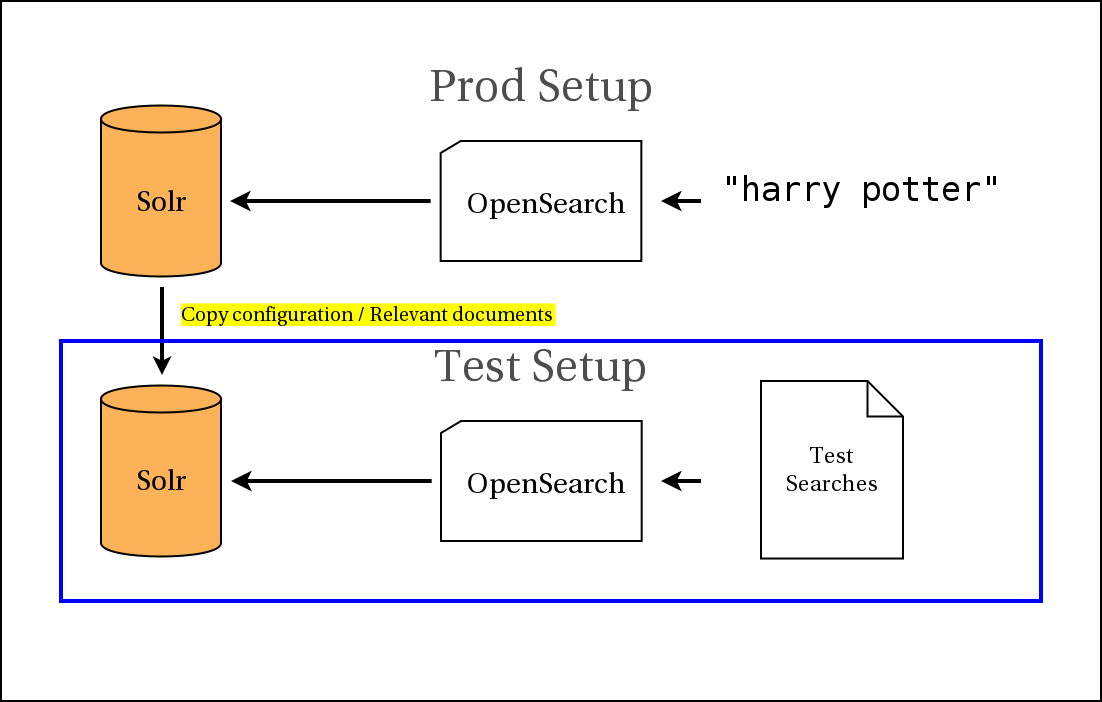

In [5]:
display(Image(filename='images/test-setup.png'))

## Test opsætning

Test opsætningen består af følgende dele:

* Solr  
  - Solr'en er baseret på DBCs dockerimage, og ved deploy bliver konfigurationen fra cisterne kopieret, så kopien har samme indekser og opførsel i test som i drift.
  - Efter start af solr'en bliver relevante dokumenter kopieret.  
    For hvert pid i testsættet bliver værket identificeret, og alle solrdokumenter med en reference til værket bliver fundet og kopieret.
* OpenSearch  
  En OpenSearch instans der peger på test-solr'en

  
# Metrikker

## precision

Precision er den fraktion af dokumenter i søgeresultatet der er relevante.

$$\frac{|\{relevant\;documents\} \cap \{retrieved\:documents\}|}{|\{retreived\;documents\}|}$$


## recall
Recall er den fraktion af relevante resultater der er returneret i søgeresultatet.

$$\frac{|\{relevant\;documents\} \cap \{retrieved\:documents\}|}{|\{relevant\;documents\}|}$$

## f-measure

f-measure er en kombination af precision og recall (harmoniske gennemsnit).

$$\frac{precision \cdot recall}{precision + recall}$$


## DCG og nDCG

_Discounted Cumulative Gain_ og _Normalized Discounted Cumulative Gain_ Er en måde at måle kvaliteten af rankering (nDCG er normaliseret og kan bruges til at sammenligne på tværs af søgninger/testsæt odv).

### CG (Cumulative Gain)
_Cumulative Gain_ er summen af evaluaringerne for et givent søgeresultat og tager ikke højde for rankeringen i resultatet.

$$CG_p = \sum_{i=1}^p rel_i$$

### DCG

_Discounted Cumulative Gain_ tager højde for ordenen af søgeresultatet. Relevante dokumenter der ligger længere ned i søgeresultatet får en lavere værdi en et tilsvarende dokument i toppen. Dokumenterne relevans bliver reduceret logarimisk propertionelt med deres position i søgelisten.

$$DCG_p = \sum_{i=1}^p \frac{rel_i}{log_2(i+1)}$$

### Normalized DCG

Da længden af søgeresultatet afhænger af søgningen kan man ikke sammenligne _DCG_ på tværs af forskellige søgninger. For at kunne gøre dette normaliseres _DCG_ ved at dividere værdien med det optimale søgeresultat _Ideal DCG_ (_IDCG_).
Det optimale søgeresultat laves ved at sortere samtlige relevante dokumenter for søgningen og tage de top-p mest relevante. Herefter kan _nDCG_ udregnes:

$$nDCG_p \frac{DCG_p}{IDCG_p}$$

hvor _IDCG_ er:

$$IDCG_p = \sum_{i=1}^{|REL_p|} \frac{2^{rel_i}-1}{log_2(i+1)}$$

og $REL_p$ er den sorterede liste af de mest relevante resultater.

# Resultater

In [6]:
def perform_search(query_fun):
    """ Perform searches for all queries in testset """
    print("Q", query_fun)
    results = []
    test_dfs = []

    for query, ground_truth_df in tqdm(get_all_query_and_rating_dataframes_from_file(f'{data_path}/master.csv')):
        search_result = query_fun(query)
        pid2work = tools.pid2work(set(search_result + ground_truth_df.pid.tolist()))
        search_result = [pid2work[p] for p in search_result]
        ground_truth_df.pid = ground_truth_df.pid.map(pid2work)
        test_df = tools.combine_search_result_and_ground_truth(search_result, ground_truth_df)
        if len(ground_truth_df) >= 5 and len(test_df) >= 5:
            result = {'query': query,
                      'precision': metrics.precision(ground_truth_df, test_df, k=5),
                      'recall': metrics.recall(ground_truth_df, test_df, k=5),
                      'f-measure': metrics.f_measure(ground_truth_df, test_df, k=5),
                      'nDCG': metrics.dcg(ground_truth_df, test_df, k=10, norm=True)}
            results.append(result)
            test_dfs.append(test_df)

    results = pd.DataFrame(results, columns=['query', 'precision', 'recall', 'f-measure', 'nDCG'])
    return results, test_dfs

def get_ratings(test_dfs, p_len=15):
    """ Retrieve ratings from test dataframes """
    ratings_ = [df['rating'].to_list() for df in test_dfs]

    def pad(lst, p_len=15, p_val=-1):
        lst = lst[:p_len]
        pad_ = [p_val] * (p_len - len(lst))
        return lst + pad_

    ratings_ = np.array([pad(lst, p_len=p_len) for lst in ratings_]).astype(float)
    ratings_ = ratings_.T
    return ratings_

def show_subset(ratings, results, n=15, cmap=plt.cm.Greens):
    """ Figure of the first n searches """
    plt.rcParams['figure.figsize'] = [20, 20]
    fig, ax = plt.subplots()
    ax.matshow(ratings[:,:n], cmap=cmap)

    for i in range(n):
        for j in range(ratings.shape[0]):
            c = ratings[j,i]
            ax.text(i, j, str(c), va='center', ha='center')

    plt.xticks(range(n), results['query'][:n], rotation='vertical')
    plt.show()


def show_all(ratings, results, cmap=plt.cm.Greens):
    """ Figure of all searches """
    plt.rcParams['figure.figsize'] = [20, 20]
    fig, ax = plt.subplots()
    ax.matshow(ratings, cmap=cmap)
    plt.xticks(range(len(results)), results['query'], rotation='vertical')
    plt.show()

In [7]:
def simple_search(query):
    url = "http://simple-search-1-0.mi-prod.svc.cloud.dbc.dk/search"
    r = requests.post(url, data=json.dumps({"q": query}))
    r.raise_for_status()
    resp = r.json()
    pids = [d["pids"][0] for d in resp["result"]]
    return pids

In [8]:
search_results, search_test_dfs = perform_search(lambda q: simple_search(q))
search_ratings = get_ratings(search_test_dfs)

0it [00:00, ?it/s]

Q <function <lambda> at 0x7f3ee5681790>


77it [00:23,  3.26it/s]


In [9]:
search_results.head(10)

,query,precision,recall,f-measure,nDCG
0,harry potter,0.6,0.6,0.6,0.669264
1,lucinda riley,0.2,0.2,0.2,0.337771
2,jeffrey archer,0.6,0.6,0.6,0.715417
3,leonora christina skov,0.8,0.8,0.8,0.821019
4,"den, der lever stille",0.2,0.2,0.2,0.360779
5,sense,0.4,0.4,0.4,0.367114
6,k for klara,0.0,0.0,0.0,0.000000
7,alt for damerne,0.2,0.2,0.2,0.300049
8,kaptajn underhyler,0.8,0.8,0.8,0.658388
9,sara blædel,0.4,0.4,0.4,0.398126


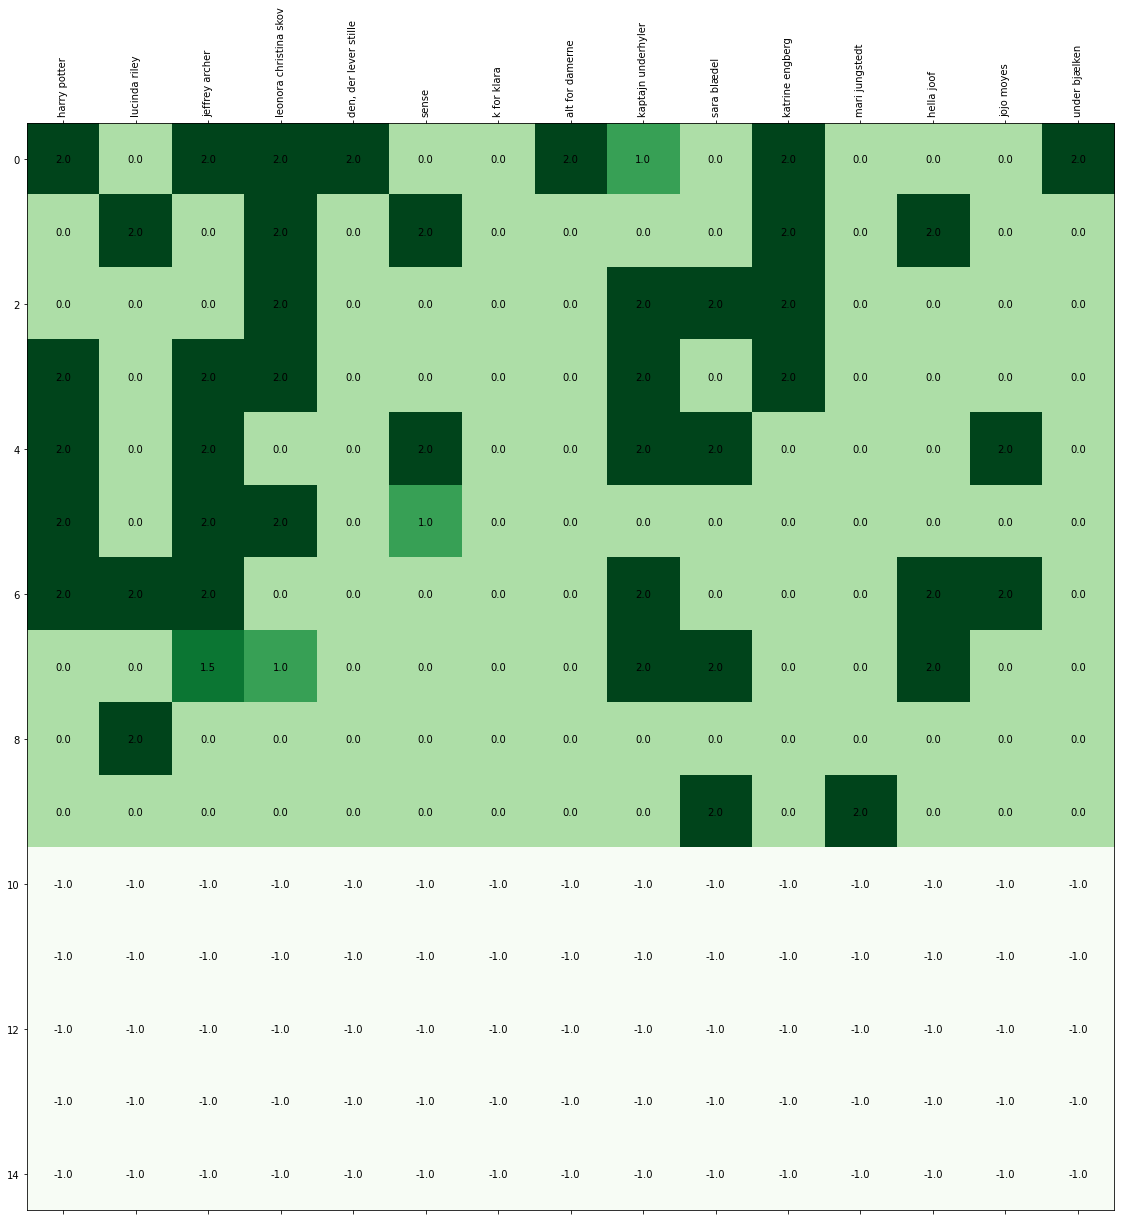

In [10]:
show_subset(search_ratings, search_results)

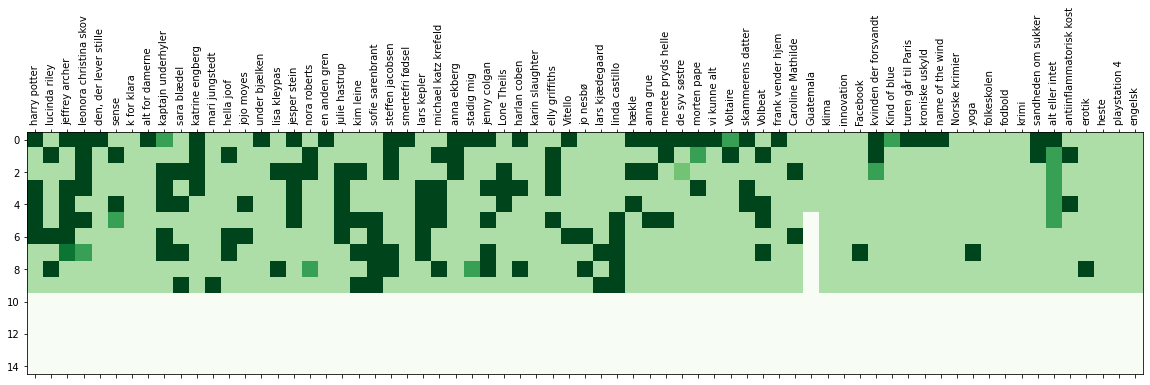

In [11]:
show_all(search_ratings, search_results)